In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import poisson
from joblib import Parallel, delayed
import time
import sys
from scipy.optimize import minimize, Bounds, LinearConstraint, minimize_scalar

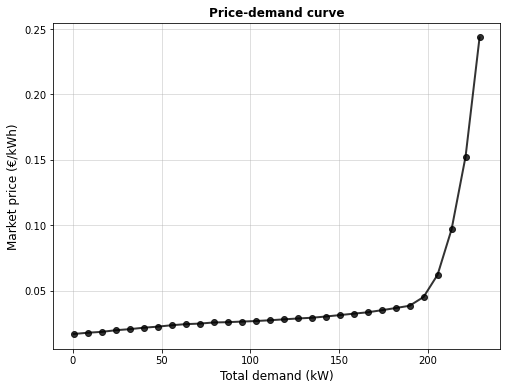

In [68]:
# Import market price (MW, Euro/MWh)
from scipy.interpolate import interp1d
market_price_data = np.loadtxt('data/market_price_UK.csv', delimiter=',')

# rescaling of the total demand to fit the simulation
tot_demand = market_price_data[:, 0] * 110 - 250

market_price = interp1d(tot_demand, market_price_data[:, 1] / 1000, kind='cubic')
x = np.linspace(tot_demand[0], tot_demand[-1], 30)
plt.figure(figsize=(8,6))
plt.plot(x, market_price(x), '-o', lw=2, c='black', alpha=0.8)
plt.xlabel('Total demand (kW)', size=12)
plt.ylabel('Market price (€/kWh)', size=12)
plt.title('Price-demand curve', size=12, fontweight='bold')
plt.grid(alpha=0.5)

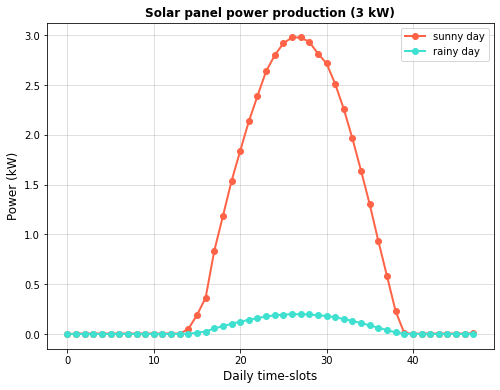

In [69]:
# import photovoltaic system power profiles
s = pd.read_csv('data/panel_power.csv', delimiter=',', usecols=[1,2,3,4])
plt.figure(figsize=(8,6))
plt.xlabel('Daily time-slots', size=12)
plt.ylabel('Power (kW)', size=12)
plt.title('Solar panel power production (3 kW)', size=12, fontweight='bold')
plt.plot(s.time*2, s.sunny, '-o', c='tomato', lw=2, label='sunny day')
plt.plot(s.time*2, s.rainy, '-o', c='turquoise', lw=2, label='rainy day')
plt.legend();
plt.grid(alpha=0.5)

### Functions

In [70]:
# Customer's utility function: for optimizing wrt b_pm
def u(b_pm, p, l, s):
    """
    b_pm: charging profile (1x2T)
    p: price vector (1xT)
    b_m: discharging profile (1xT)
    l: load profile (1xT)
    c: running cost of storage
    s: power supply from energy generators 
    
    """
    return np.sum(p * (b_pm[:T] - alpha * b_pm[T:] + l - s))

def constr_matrix_b(alpha):
    """
    alpha: efficiency
    """
    # storage efficiency
    mat1 = np.zeros(shape=(1, 2*T), dtype='float')
    for j in range(T):
        mat1[0, j] = -1
        mat1[0, j+T] = 1

    # within charging and discharging capacity
    mat2 = np.hstack([np.identity(T, dtype='float'), np.zeros(shape=(T, T), dtype='float')])
    mat3 = np.hstack([np.zeros(shape=(T, T), dtype='float'), np.identity(T, dtype='float')])

    # energy that can be stored or used at a time slot
    mat4 = np.zeros(shape=(T, 2*T), dtype='float')
    for i in range(1, T):
        mat4[i, :i] = -1
        mat4[i, T:T+i] = 1
    for i in range(T):
        mat4[i, T+i] = 1

    mat5 = np.zeros(shape=(T, 2*T), dtype='float')
    for i in range(1, T):
        mat5[i, :i] = 1
        mat5[i, T:T+i] = -1
    for i in range(T):
        mat5[i, i] = 1    

    return np.vstack([mat1, mat2, mat3, mat4, mat5])

def constr_vectors_b(b_sup, b_inf, alpha, e0, e, l):
    """
    n: customer's index
    """
    # left
    leftv1 = np.zeros(1)          # bilateral
    leftv2 = np.zeros(T)          # bilateral
    leftv3 = np.zeros(T)          # bilateral
    leftv4 = -np.ones(T)*np.inf   # unilateral
    leftv5 = -np.ones(T)*np.inf   # unilateral
    leftv_constr = np.concatenate([leftv1, leftv2, leftv3, leftv4, leftv5])

    # right
    rightv_constr = np.concatenate([[0], [b_sup] * T, [b_inf] * T, [e0] * T, [e - e0] * T])
    return leftv_constr, rightv_constr

def optimize_b(f, b_sup, b_inf, p, alpha, e0, e, l, x0, s):
    mat_constr = constr_matrix_b(alpha)
    leftv_constr, rightv_constr = constr_vectors_b(b_sup, b_inf, alpha, e0, e, l)
    linear_constraint = LinearConstraint(mat_constr, leftv_constr, rightv_constr)
    bounds = Bounds([0] * 2 * T, [max(b_sup, b_inf)] * 2 * T)
    b_opt = minimize(f, x0, args=(p, l, s), method='trust-constr',
        constraints=linear_constraint,
        bounds=bounds,
        options={'verbose' : 0})
    return b_opt.x

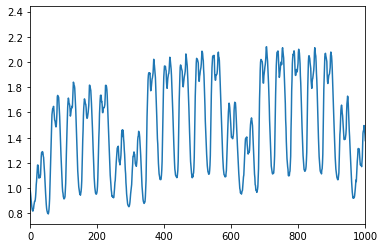

In [25]:
# import load profiles
load_curve_tot = np.load('data/load_agg_real.npy')
plt.plot(load_curve_tot)
plt.xlim(0,1000);

### Parameters

In [71]:
n_nodes = 100          # total number of consumers
n_smart = 30           # consumers with storage and renewable energy
n_a = int(n_smart / 2) # number of aware
n_u = n_smart - n_a    # number of unaware
T = 48                 # number of time slots in a day(1 slot = 0.5 hours)
n_days = 30            # number of days to simulate 
beta = 0.1             # storage profile learning rate
b_inf = 0.2            # maximum discharge in a time slot (kWh)
b_sup = 0.2            # maximum charge in a time slot(kWh)
alpha = 0.8            # efficiency
e = 5.                 # storage capacity

weather = ['sunny'] * n_days
#rain_indices = [8, 9, 10, 16, 17, 25, 26, 27, 28, 36, 37, 45, 46, 47, 55, 56, 60,
#               70, 71, 72, 73, 74, 89, 90, 91]
rain_indices = [4,5,6,12,13,20,21,22,23]
for i in rain_indices:
    weather[i] = 'rainy'

l = np.ndarray(shape=(0, T))
for i in range(n_nodes):
    l = np.append(l, [load_curve_tot[i:i+T]], axis=0)

In [72]:
# import best-response profles
br_b_sun = np.load('Results/b_history-sunny-100d.npy')[-1]
br_b_rain = np.load('Results/b_history-rainy-100d.npy')[-1]

# Aware

In [73]:
# Intialization
e0 = np.zeros(n_smart)                           # storage level
b_pm_sun = br_b_sun                              # charging profiles sunny day
b_pm_rain = br_b_rain                            # charging profiles rainy day
b_history = np.ndarray(shape=(0, n_a, 2*T))      # storage profile history
p_history_sun = np.ndarray(shape=(0, T))
p_history_rain = np.ndarray(shape=(0, T))

p_sun = market_price(l.sum(axis=0) - alpha * b_pm_sun[:, T:].sum(axis=0) + b_pm_sun[:, :T].sum(axis=0))
p_rain = market_price(l.sum(axis=0) - alpha * b_pm_rain[:, T:].sum(axis=0) + b_pm_rain[:, :T].sum(axis=0))
p_history_sun = np.append(p_history_sun, [p_sun], axis=0)
p_history_rain = np.append(p_history_rain, [p_rain], axis=0)
u_history = np.ndarray(shape=(0, n_smart))
b_history = np.ndarray(shape=(0, n_smart, 2*T))

In [74]:
for d in range(n_days):
    t_start = time.time()
    if weather[d] == 'sunny':
        p = p_sun
        p_history = p_history_sun
        b_pm = b_pm_sun
        br_b = br_b_sun
    else:
        p = p_rain
        p_history = p_history_rain
        b_pm  = b_pm_rain
        br_b = br_b_rain
    
    # optimize b aware
    b_opt_a = np.ndarray(shape=(0, 2*T))
    with Parallel(n_jobs=n_smart) as parallel:
        b_opt_a_list = parallel(delayed(optimize_b)\
                              (u, b_sup, b_inf, p, alpha, e0[n],
                               e, l[n, :], br_b[n], s[weather[d]]) for n in range(n_a))
    for n in range(n_a):
        b_opt_a = np.append(b_opt_a, [b_opt_a_list[n]], axis=0)
        
    # update stoage profile
    b_pm[:n_a] = br_b[:n_a] + beta * (br_b[:n_a] - b_opt_a)
    b_pm[n_a : n_a + n_u] = (b_pm[n_a : n_a + n_u] + br_b[n_a:]) / 2
    
    # update prices
    p_new = market_price(l.sum(axis=0) + b_pm[:, :T].sum(axis=0) - alpha * b_pm[:, T:].sum(axis=0) - n_smart * s[weather[d]])
    p = (p + p_new) / 2
    p_history = np.append(p_history, [p], axis=0)
    u_new = [np.sum(p * (l[n, :] + b_pm[n, :T] - alpha * b_pm[n, T:] - s[weather[d]])) for n in range(n_smart)]
    u_history = np.append(u_history, [u_new], axis=0)
    b_history = np.append(b_history, [b_pm], axis=0)
    t_stop = time.time()
    time_elapsed = round((t_stop - t_start)/60, 2)
    print('completed day {d}/{n_days} in {mins} min'.format(d=d+1, n_days=n_days, mins=time_elapsed))

completed day 1/30 in 0.08 min
completed day 2/30 in 0.08 min
completed day 3/30 in 0.08 min
completed day 4/30 in 0.08 min
completed day 5/30 in 0.08 min
completed day 6/30 in 0.09 min
completed day 7/30 in 0.08 min
completed day 8/30 in 0.08 min
completed day 9/30 in 0.08 min
completed day 10/30 in 0.09 min
completed day 11/30 in 0.09 min
completed day 12/30 in 0.08 min
completed day 13/30 in 0.09 min
completed day 14/30 in 0.08 min
completed day 15/30 in 0.08 min
completed day 16/30 in 0.08 min
completed day 17/30 in 0.09 min
completed day 18/30 in 0.09 min
completed day 19/30 in 0.09 min
completed day 20/30 in 0.08 min
completed day 21/30 in 0.08 min
completed day 22/30 in 0.08 min
completed day 23/30 in 0.09 min
completed day 24/30 in 0.09 min
completed day 25/30 in 0.09 min
completed day 26/30 in 0.09 min
completed day 27/30 in 0.09 min
completed day 28/30 in 0.09 min
completed day 29/30 in 0.09 min
completed day 30/30 in 0.08 min


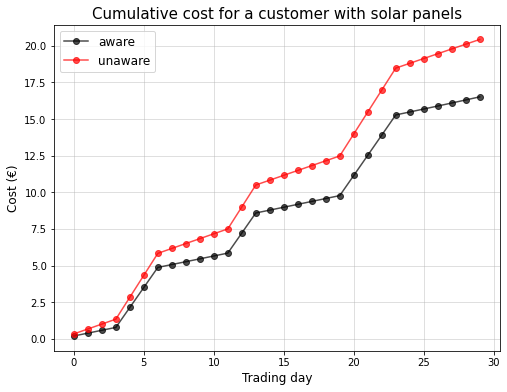

In [82]:
plt.figure(figsize=(8,6))
plt.title('Cumulative cost for a customer with solar panels', size=15)
plt.xlabel('Trading day', size=12)
plt.ylabel('Cost (€)', size=12)
plt.plot(u_history[:, :n_a].mean(axis=1).cumsum(), '-o', c='black', alpha=0.7, label='aware')
plt.plot(u_history[:, n_a:].mean(axis=1).cumsum(), '-o', c='red', alpha=0.7, label='unaware')
plt.grid(alpha=0.5)
plt.legend(fontsize=12);

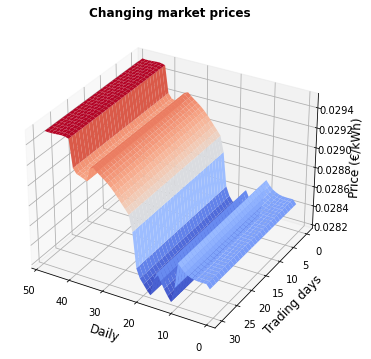

In [76]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8,6))
X = np.arange(1, T+1, 1)
Y = np.arange(0, n_days+1, 1)
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(X, Y, p_history_rain, cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)
ax.set_ylabel('Trading days', size=12)
ax.set_xlabel('Daily', size=12)
ax.set_zlabel('Price (€/kWh)', size=12)
#fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(30, 120)
ax.set_title('Changing market prices', size=12, fontweight='bold');

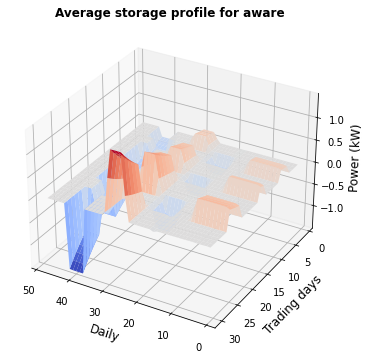

In [81]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8,6))
X = np.arange(1, T+1, 1)
Y = np.arange(1, n_days+1, 1)
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(X, Y, b_history[:, :n_a, :T].mean(axis=1) - b_history[:, :n_a, T:].mean(axis=1), cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)
ax.set_ylabel('Trading days', size=12)
ax.set_xlabel('Daily', size=12)
ax.set_zlabel('Power (kW)', size=12)
#fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(30, 120)
ax.set_title('Average storage profile for aware', size=12, fontweight='bold');

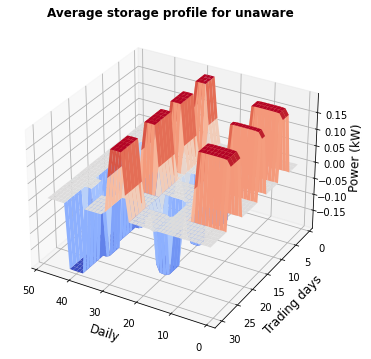

In [80]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(8,6))
X = np.arange(1, T+1, 1)
Y = np.arange(1, n_days+1, 1)
X, Y = np.meshgrid(X, Y)
surf = ax.plot_surface(X, Y, b_history[:, n_a:, :T].mean(axis=1) - b_history[:, n_a:, T:].mean(axis=1), cmap=cm.coolwarm,
                       linewidth=0, antialiased=True)
ax.set_ylabel('Trading days', size=12)
ax.set_xlabel('Daily', size=12)
ax.set_zlabel('Power (kW)', size=12)
#fig.colorbar(surf, shrink=0.5, aspect=5)
ax.view_init(30, 120)
ax.set_title('Average storage profile for unaware', size=12, fontweight='bold');

In [87]:
coll = np.ndarray(shape=(0, 3))
a = np.array([1,2,3])
b = np.array([9,8,7])
c = ['c', 'b', 'b', 'c']
for i in c:
    if i == 'c':
        p = a
    else:
        p = b
    p[2] += 1
    coll = np.append(coll, [p], axis=0)

print(coll)

[[1. 2. 4.]
 [9. 8. 8.]
 [9. 8. 9.]
 [1. 2. 5.]]
